In [7]:
#!/usr/bin/env python

import healpy as hp
import numpy as np
import fitsio
import glob
import os

from astropy.table import Table, hstack, vstack
from functions import match_hpx_index
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

This notebook intends to display the results of the Monte-Carlo simulation run with the DECALS COSMOS DEEP truth sample on only one healpixel of the DR9 map. The first part contains all the pipeline of the simulation used in MC_decam_parallelized.py and the second part shows some plots and results.

# 1 - Run the Monte-Carlo simulation

## Catalogs

In [8]:
# -------------------------------- LOAD THE CATALOGS --------------------------------------------

#The catalogs must have been cleaned already
print("reading truth sample...")
filename="maps-data/DECAM_truth_sample.csv"
t=Table.read(filename)
print("read",filename)
print(t.dtype.names)
print(str(len(t)) + " objects in the HSC truth sample")

print("\nreading LS catalog...")
filename="maps-data/LS_healpix_map.csv"
t_ls=Table.read(filename)
print("read",filename)
print(t_ls.dtype.names)
print(str(len(t_ls)) + " pixels in DR9")

reading truth sample...
read maps-data/DECAM_truth_sample.csv
('release', 'brickname', 'objid', 'brick_primary', 'maskbits', 'type', 'ra', 'dec', 'ebv', 'flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'flux_ivar_g', 'flux_ivar_r', 'flux_ivar_z', 'flux_ivar_w1', 'flux_ivar_w2', 'fiberflux_g', 'fiberflux_r', 'fiberflux_z', 'mw_transmission_g', 'mw_transmission_r', 'mw_transmission_z', 'mw_transmission_w1', 'mw_transmission_w2', 'nobs_g', 'nobs_r', 'nobs_z', 'nobs_w1', 'nobs_w2', 'psfsize_g', 'psfsize_r', 'psfsize_z', 'psfdepth_g', 'psfdepth_r', 'psfdepth_z', 'galdepth_g', 'galdepth_r', 'galdepth_z', 'nea_g', 'nea_r', 'nea_z', 'blob_nea_g', 'blob_nea_r', 'blob_nea_z', 'sersic', 'shape_r', 'shape_e1', 'shape_e2', 'hpxpixel', 'g', 'r', 'z', 'gfib')
46812 objects in the HSC truth sample

reading LS catalog...
read maps-data/LS_healpix_map.csv
('HPXPIXEL', 'FRACAREA', 'STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSF

## MC pipeline

In [13]:
# ratio_density = t["ratio_density"][0]

def mag_from_flux(flux):
    return 22.5 - 2.5*np.log10(flux)

# -------------------------------- TRACTOR DETECTION --------------------------------------------

def sed_filters():
    SEDs   = []
    bands  = ['g','r','z']
    for i,band in enumerate(bands):
        sed    = np.zeros(len(bands))
        sed[i] = 1.
        SEDs.append((band, sed))
    # Reverse the order -- run z-band detection filter *first*.
    SEDs = list(reversed(SEDs))
    # flat , red sed
    if len(bands) > 1:
        flat = dict(g=1., r=1., i=1., z=1.)
        SEDs.append(('Flat', [flat[b] for b in bands]))
        red = dict(g=2.5, r=1., i=0.4, z=0.4)
        SEDs.append(('Red', [red[b] for b in bands]))
    return SEDs

def isdetect(SEDs, flux_g,flux_r,flux_z,flux_ivar_g,flux_ivar_r,flux_ivar_z):
    nobj                 = len(flux_g)
    # putting in a dictionary
    fdict                = {}
    fdict['flux_g']      = flux_g
    fdict['flux_r']      = flux_r
    fdict['flux_z']      = flux_z
    fdict['flux_ivar_g'] = flux_ivar_g
    fdict['flux_ivar_r'] = flux_ivar_r
    fdict['flux_ivar_z'] = flux_ivar_z
    #
    bands  = ['g','r','z']
    nsigma = 6
    
    peaks = np.zeros(nobj,dtype=bool)
    for sedname,sed in SEDs:
        sedmap = np.zeros(nobj)
        sediv  = np.zeros(nobj)
        for iband,band in enumerate(bands):
            if (sed[iband]!=0):
                # We convert the detmap to canonical band via
                #   detmap * w
                # And the corresponding change to sig1 is
                #   sig1 * w
                # So the invvar-weighted sum is
                #    (detmap * w) / (sig1**2 * w**2)
                #  = detmap / (sig1**2 * w)
                sedmap += fdict['flux_'+band] * fdict['flux_ivar_'+band] / sed[iband]
                sediv  += fdict['flux_ivar_'+band] / sed[iband]**2
        sedmap /= np.maximum(1e-16, sediv)
        sedsn   = sedmap * np.sqrt(sediv)
        del sedmap
        peaks[sedsn>nsigma] = True
    return peaks


# -------------------------------- ELG SELECTION --------------------------------------------

def is_ELG(g, r, z, gfib):
    x = r-z
    y = g-r
    return (g>20) & (gfib<24.1) & (x>0.15) & (y < 0.5*x+0.1) & (y < -1.2*x+1.6)

def is_ELG_lop(g, r, z, gfib):
    x = r-z
    y = g-r
    return (g>20) & (gfib<24.1) & (x>0.15) & (y < 0.5*x+0.1) & (y < -1.2*x+1.3)

def is_ELG_vlo(g, r, z, gfib):
    x = r-z
    y = g-r
    return (g>20) & (gfib<24.1) & (x>0.15) & (y < 0.5*x+0.1) & (y > -1.2*x+1.3) & (y < -1.2*x+1.6)

# -------------------------------- MONTE-CARLO NOISE --------------------------------------------

def random_MC_noise(t_truth, seds, ihpx):
    
    #True flux, corrected from the truth catalog extinction
    flux_g0 = t_truth['flux_g'] / t_truth["mw_transmission_g"]
    flux_r0 = t_truth['flux_r'] / t_truth["mw_transmission_r"]
    flux_z0 = t_truth['flux_z'] / t_truth["mw_transmission_z"]
    fiberflux_g0 = t_truth['fiberflux_g'] / t_truth["mw_transmission_g"]
    
    #Measurement equivalent of the true flux (inverse correction with the LS extinction): the flux is now the one that would have been obtained in LS DR9.
    flux_g0 = flux_g0 * (10**(-0.4*3.214*t_ls["EBV"][ihpx]))
    flux_r0 = flux_r0 * (10**(-0.4*2.165*t_ls["EBV"][ihpx]))
    flux_z0 = flux_z0 * (10**(-0.4*1.211*t_ls["EBV"][ihpx]))
    fiberflux_g0 = fiberflux_g0*(10**(-0.4*3.214*t_ls["EBV"][ihpx]))
    
    #Adapt the noise to the size
    # true_depth_g =  t_ls["PSFDEPTH_G"][ihpx] / (1+1.30*(t_truth["shape_r"]**2/(0.45**2))/t_ls["PSFSIZE_G"][ihpx]**2)
    # true_depth_r =  t_ls["PSFDEPTH_R"][ihpx] / (1+1.30*(t_truth["shape_r"]**2/(0.45**2))/t_ls["PSFSIZE_R"][ihpx]**2)
    # true_depth_z =  t_ls["PSFDEPTH_Z"][ihpx] / (1+1.30*(t_truth["shape_r"]**2/(0.45**2))/t_ls["PSFSIZE_Z"][ihpx]**2)
    #OR
    #Adapt the noise to the size using the NEA, with NEA inference from LS, see https://www.legacysurvey.org/dr9/nea/
    nea_g = t_truth["blob_nea_g"] * (t_ls["PSFSIZE_G"][ihpx]**2 + 1.30*(t_truth["shape_r"]**2/(0.45**2))) / (t_truth["psfsize_g"]**2 + 1.30*(t_truth["shape_r"]**2/(0.45**2)))
    nea_r = t_truth["blob_nea_r"] * (t_ls["PSFSIZE_R"][ihpx]**2 + 1.30*(t_truth["shape_r"]**2/(0.45**2))) / (t_truth["psfsize_r"]**2 + 1.30*(t_truth["shape_r"]**2/(0.45**2)))
    nea_z = t_truth["blob_nea_z"] * (t_ls["PSFSIZE_Z"][ihpx]**2 + 1.30*(t_truth["shape_r"]**2/(0.45**2))) / (t_truth["psfsize_z"]**2 + 1.30*(t_truth["shape_r"]**2/(0.45**2)))
    true_depth_g =  t_ls["PSFDEPTH_G"][ihpx] * 4*np.pi * (t_ls["PSFSIZE_G"][ihpx]/2.3548)**2 / nea_g 
    true_depth_r =  t_ls["PSFDEPTH_R"][ihpx] * 4*np.pi * (t_ls["PSFSIZE_R"][ihpx]/2.3548)**2 / nea_r
    true_depth_z =  t_ls["PSFDEPTH_Z"][ihpx] * 4*np.pi * (t_ls["PSFSIZE_Z"][ihpx]/2.3548)**2 / nea_z 
    
    #Add the random noise to the truth flux
    noise_g = (1/np.sqrt(true_depth_g))*np.random.normal(0, 1, len(t_truth))
    flux_g = flux_g0 + noise_g
    flux_r = flux_r0 + (1/np.sqrt(true_depth_r))*np.random.normal(0, 1, len(t_truth))
    flux_z = flux_z0 + (1/np.sqrt(true_depth_z))*np.random.normal(0, 1, len(t_truth))
    fiberflux_g = fiberflux_g0 + noise_g * fiberflux_g0/flux_g0
    
    #Control positive flux: if negative, very small SNR and the object will be discarded
    flux_g[flux_g<=0] = 1e-12
    flux_r[flux_r<=0] = 1e-12
    flux_z[flux_z<=0] = 1e-12
    fiberflux_g[fiberflux_g<=0] = 1e-12
    
    #Detection according to the Tractor pipeline, performed on non-corrected fluxes
    detect = isdetect(seds, flux_g, flux_r, flux_z, true_depth_g, true_depth_r, true_depth_z)
    
    #Convert into magnitudes and correct for extinction for the selection
    g = mag_from_flux(flux_g) - 3.214*t_ls["EBV"][ihpx]
    r = mag_from_flux(flux_r) - 2.165*t_ls["EBV"][ihpx]
    z = mag_from_flux(flux_z) - 1.211*t_ls["EBV"][ihpx]
    gfib = mag_from_flux(fiberflux_g) - 3.214*t_ls["EBV"][ihpx]
    
    return g, r, z, gfib, detect


def random_MC_noise_inverted(t_truth, seds, ihpx):

    #True flux, corrected from the truth catalog extinction
    flux_g0 = t_truth['flux_g'] / t_truth["mw_transmission_g"]
    flux_r0 = t_truth['flux_r'] / t_truth["mw_transmission_r"]
    flux_z0 = t_truth['flux_z'] / t_truth["mw_transmission_z"]
    fiberflux_g0 = t_truth['fiberflux_g'] / t_truth["mw_transmission_g"]
    
    #Adapt the noise to the size
    # true_depth_g =  t_ls["PSFDEPTH_G"][ihpx] / (1+1.30*(t_truth["shape_r"]**2/(0.45**2))/t_ls["PSFSIZE_G"][ihpx]**2)
    # true_depth_r =  t_ls["PSFDEPTH_R"][ihpx] / (1+1.30*(t_truth["shape_r"]**2/(0.45**2))/t_ls["PSFSIZE_R"][ihpx]**2)
    # true_depth_z =  t_ls["PSFDEPTH_Z"][ihpx] / (1+1.30*(t_truth["shape_r"]**2/(0.45**2))/t_ls["PSFSIZE_Z"][ihpx]**2)
    # OR
    #Adapt the noise to the size using the NEA, with NEA inference from LS, see https://www.legacysurvey.org/dr9/nea/
    nea_g = t_truth["blob_nea_g"] * (t_ls["PSFSIZE_G"][ihpx]**2 + 1.30*(t_truth["shape_r"]**2/(0.45**2))) / (t_truth["psfsize_g"]**2 + 1.30*(t_truth["shape_r"]**2/(0.45**2)))
    nea_r = t_truth["blob_nea_r"] * (t_ls["PSFSIZE_R"][ihpx]**2 + 1.30*(t_truth["shape_r"]**2/(0.45**2))) / (t_truth["psfsize_r"]**2 + 1.30*(t_truth["shape_r"]**2/(0.45**2)))
    nea_z = t_truth["blob_nea_z"] * (t_ls["PSFSIZE_Z"][ihpx]**2 + 1.30*(t_truth["shape_r"]**2/(0.45**2))) / (t_truth["psfsize_z"]**2 + 1.30*(t_truth["shape_r"]**2/(0.45**2)))
    true_depth_g =  t_ls["PSFDEPTH_G"][ihpx] * 4*np.pi * (t_ls["PSFSIZE_G"][ihpx]/2.3548)**2 / nea_g 
    true_depth_r =  t_ls["PSFDEPTH_R"][ihpx] * 4*np.pi * (t_ls["PSFSIZE_R"][ihpx]/2.3548)**2 / nea_r
    true_depth_z =  t_ls["PSFDEPTH_Z"][ihpx] * 4*np.pi * (t_ls["PSFSIZE_Z"][ihpx]/2.3548)**2 / nea_z 
    
    #Add the random noise to the truth flux
    noise_g = (1/np.sqrt(true_depth_g))*np.random.normal(0, 1, len(t_truth))
    flux_g = flux_g0 + noise_g
    flux_r = flux_r0 + (1/np.sqrt(true_depth_r))*np.random.normal(0, 1, len(t_truth))
    flux_z = flux_z0 + (1/np.sqrt(true_depth_z))*np.random.normal(0, 1, len(t_truth))
    fiberflux_g = fiberflux_g0 + noise_g * fiberflux_g0/flux_g0
    
    #Control positive flux: if negative, very small SNR and the object will be discarded
    flux_g[flux_g<=0] = 1e-12
    flux_r[flux_r<=0] = 1e-12
    flux_z[flux_z<=0] = 1e-12
    fiberflux_g[fiberflux_g<=0] = 1e-12
    
    #Remove the extinction correction to yield an output of "measured" fluxes, same as input. THIS OPERATION WAS BEFORE THE ADDITIVE NOISE IN THE FUNcTION random_MC_noise
    flux_g = flux_g * (10**(-0.4*3.214*t_ls["EBV"][ihpx]))
    flux_r = flux_r * (10**(-0.4*2.165*t_ls["EBV"][ihpx]))
    flux_z = flux_z * (10**(-0.4*1.211*t_ls["EBV"][ihpx]))
    fiberflux_g = fiberflux_g*(10**(-0.4*3.214*t_ls["EBV"][ihpx]))
    
    #Detection according to the Tractor pipeline, performed on non-corrected fluxes
    detect = isdetect(seds, flux_g, flux_r, flux_z, true_depth_g, true_depth_r, true_depth_z)
    
    #Convert into magnitudes and correct for extinction for the selection
    g = mag_from_flux(flux_g) - 3.214*t_ls["EBV"][ihpx]
    r = mag_from_flux(flux_r) - 2.165*t_ls["EBV"][ihpx]
    z = mag_from_flux(flux_z) - 1.211*t_ls["EBV"][ihpx]
    gfib = mag_from_flux(fiberflux_g) - 3.214*t_ls["EBV"][ihpx]
    
    return g, r, z, gfib, detect


# -------------------------------- MONTE-CARLO ALGORITHM --------------------------------------------

def monte_carlo(t_truth, seds, ihpx):
    
    n_elg0 = np.count_nonzero(is_ELG_lop(t_truth["g"], t_truth["r"], t_truth["z"], t_truth["gfib"]))
    new_g, new_r, new_z, new_gfib, detect = random_MC_noise(t_truth, seds, ihpx)
    # new_g, new_r, new_z, new_gfib, detect = random_MC_noise_inverted(t_truth, seds, ihpx)
    n_detect = np.count_nonzero(detect)
    elgs = np.logical_and(is_ELG_lop(new_g, new_r, new_z, new_gfib), detect)
    n_elg = np.count_nonzero(elgs)
    
    return new_g, new_r, new_z, new_gfib, detect, elgs, n_elg0, n_detect, n_elg

## Simulation

In [14]:
print("\nSimulation in progress...")
SEDs = sed_filters()
#ihpx = 2500
ihpx = np.random.randint(len(t_ls))
print("Hpx n°" + str(ihpx))
res_mc = monte_carlo(t, SEDs, ihpx)
new_g, new_r, new_z, new_gfib, detect, elgs, n_elg0, n_detect, n_elg = res_mc
print("Simulation done")


Simulation in progress...
Hpx n°161671
Simulation done


# 2 - Results and plots

In [15]:
matplotlib.rcParams["figure.figsize"] = (10,8)

In [16]:
def plot_box():
    plt.vlines(x=0.15, ymin=-0.5, ymax=0.175, color='black')
    plt.plot([0.15,1.2/1.7], [0.175,0.5*1.2/1.7+0.1], color='black')
    plt.plot([1.2/1.7,1.8/1.2], [0.5*1.2/1.7+0.1,-0.5], color='black')
    plt.plot([1.2/1.7,1.5/1.7], [0.5*1.2/1.7+0.1,0.5*1.5/1.7+0.1], 'k--')
    plt.plot([1.5/1.7,2.1/1.2], [0.5*1.5/1.7+0.1,-0.5], 'k--')

In [17]:
def compute_density_color(tab_x, tab_y, n=100):
    x = np.linspace(-0.5,2., n)
    y = np.linspace(-0.5,2., n)
    x_grid, y_grid = np.meshgrid(x,y)

    density = np.zeros((n,n))

    for i in range(len(tab_x)):
        cx, cy = tab_x[i], tab_y[i]
        if (cx>=-0.5) & (cx<=2.) & (cy>=-0.5) & (cy<=2.):
            k = int(n*(cx + 0.5)/2.5)
            l = int(n*(cy + 0.5)/2.5)
            density[k,l] +=1
    return x_grid, y_grid, density

## Density in the color-color diagram

### Initial truth density

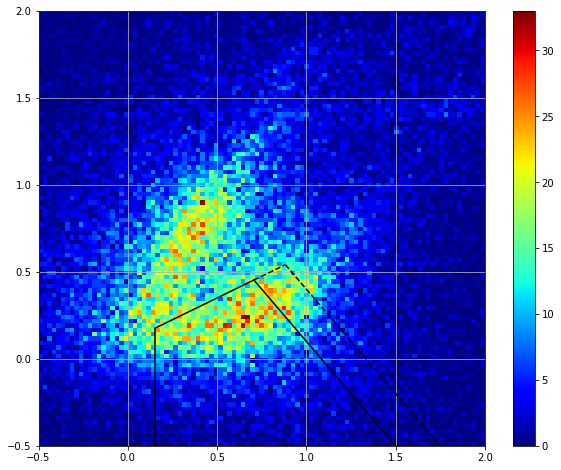

In [18]:
x_grid, y_grid, density = compute_density_color(t["r"]-t["z"], t["g"]-t["r"])
plt.pcolormesh(x_grid, y_grid, np.transpose(density), cmap='jet')
plot_box()
plt.xlim(-0.5,2.)
plt.ylim(-0.5,2.)
plt.grid()
plt.colorbar()

### Initial truth density with the g-band magnitude cuts (g>20, gfib<24.1)

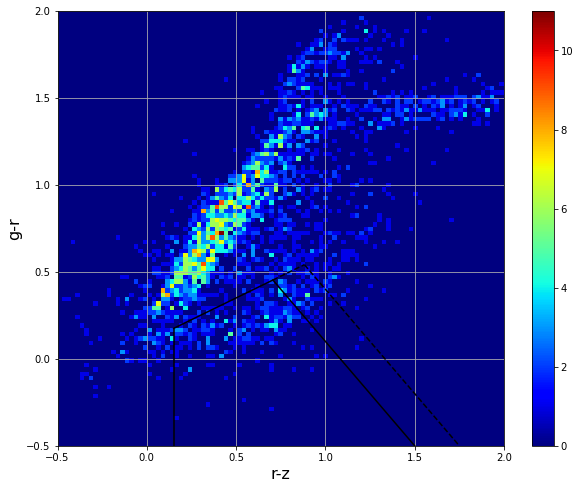

In [19]:
ii = np.where((t["g"]>20) & (mag_from_flux(t["fiberflux_g"]/t["mw_transmission_g"])<24.1))[0]

x_grid, y_grid, density = compute_density_color(t["r"][ii]-t["z"][ii], t["g"][ii]-t["r"][ii])
plt.pcolormesh(x_grid, y_grid, np.transpose(density), cmap='jet')
plot_box()
plt.xlim(-0.5,2.)
plt.ylim(-0.5,2.)
plt.xlabel("r-z", size=16)
plt.ylabel("g-r", size=16)
plt.grid()
plt.colorbar()

### Simulated density, all objects

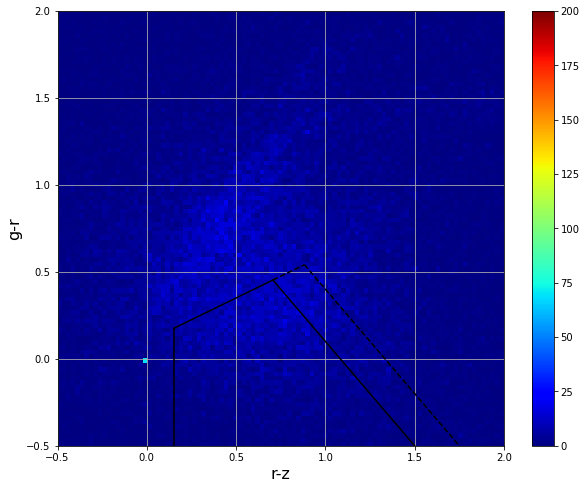

In [20]:
x_grid, y_grid, density = compute_density_color(new_r-new_z, new_g-new_r)
plt.pcolormesh(x_grid, y_grid, np.transpose(density), vmax=200, cmap='jet')
plot_box()
plt.xlim(-0.5,2.)
plt.ylim(-0.5,2.)
plt.xlabel("r-z", size=16)
plt.ylabel("g-r", size=16)
plt.grid()
plt.colorbar()

### Simulated density, detected objects

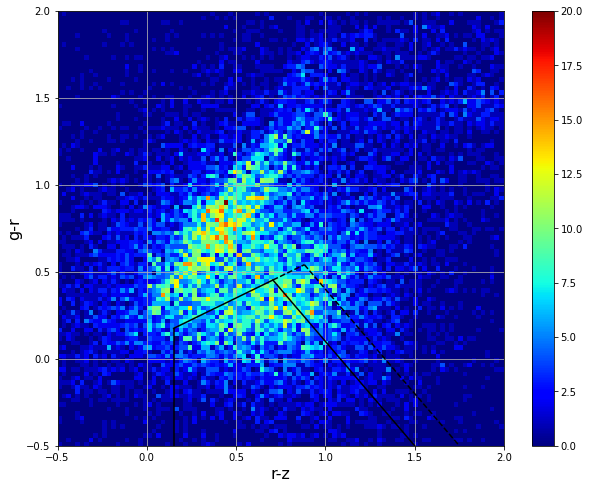

In [21]:
x_grid, y_grid, density = compute_density_color(new_r[detect]-new_z[detect], new_g[detect]-new_r[detect])
plt.pcolormesh(x_grid, y_grid, np.transpose(density), cmap='jet')
plot_box()
plt.xlim(-0.5,2.)
plt.ylim(-0.5,2.)
plt.xlabel("r-z", size=16)
plt.ylabel("g-r", size=16)
plt.grid()
plt.colorbar()

### Simulated density, detected objects, with the g-band magnitude cuts (g>20, gfib<24.1)

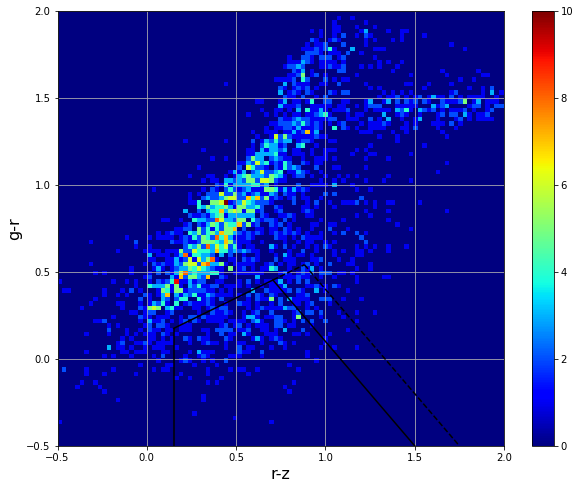

In [22]:
jj = np.where((new_g>20) & (mag_from_flux(t["fiberflux_g"]/t["mw_transmission_g"])<24.1) & detect)[0]

x_grid, y_grid, density = compute_density_color(new_r[jj]-new_z[jj], new_g[jj]-new_r[jj])
plt.pcolormesh(x_grid, y_grid, np.transpose(density), cmap='jet')
plot_box()
plt.xlim(-0.5,2.)
plt.ylim(-0.5,2.)
plt.xlabel("r-z", size=16)
plt.ylabel("g-r", size=16)
plt.grid()
plt.colorbar()

### Simulated density, ELGs

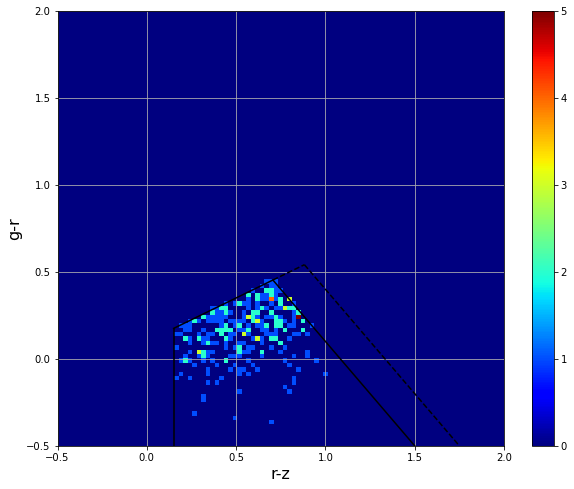

In [23]:
x_grid, y_grid, density = compute_density_color(new_r[elgs]-new_z[elgs], new_g[elgs]-new_r[elgs])
plt.pcolormesh(x_grid, y_grid, np.transpose(density), cmap='jet')
plot_box()
plt.xlim(-0.5,2.)
plt.ylim(-0.5,2.)
plt.xlabel("r-z", size=16)
plt.ylabel("g-r", size=16)
plt.grid()
plt.colorbar()

### Initial truth density of the final selected ELGs

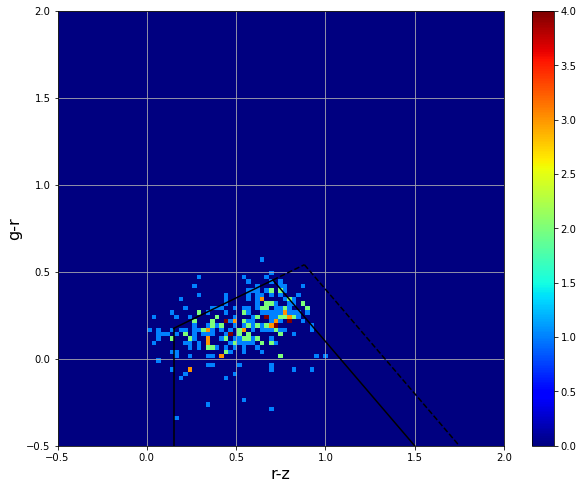

In [24]:
x_grid, y_grid, density = compute_density_color(t["r"][elgs]-t["z"][elgs], t["g"][elgs]-t["r"][elgs])
plt.pcolormesh(x_grid, y_grid, np.transpose(density), cmap='jet')
plot_box()
plt.xlim(-0.5,2.)
plt.ylim(-0.5,2.)
plt.xlabel("r-z", size=16)
plt.ylabel("g-r", size=16)
plt.grid()
plt.colorbar()

## Histogram vs colors

The purpose of this section is to show the effect of a cut on the density distribution, for each cut (g, gfib, r-z, g-r). Some cuts appear to take place in regions with huge variations of the quantity: their effect is therefore important and the consequences on the selected sample are very sensible to the value of the cut.

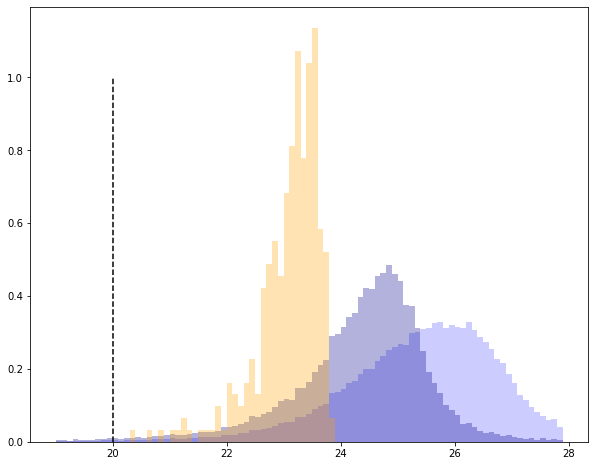

In [25]:
plt.hist(t["g"], np.arange(19, 28, 0.1), alpha=0.2, color='blue', density=True)
plt.hist(t["g"][detect], np.arange(19, 28, 0.1), alpha=0.3, color='darkblue', density=True)
plt.hist(new_g[elgs], np.arange(19, 28, 0.1), alpha=0.3, color='orange', density=True)
plt.vlines(20,0,1,'k','dashed') 

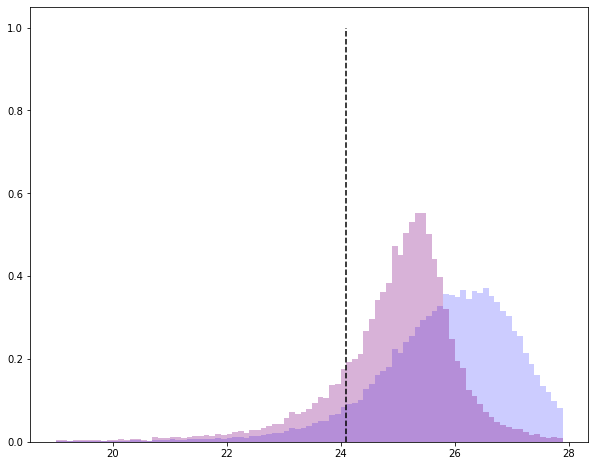

In [26]:
plt.hist(t["gfib"], np.arange(19, 28, 0.1), alpha=0.2, color='blue', density=True)
plt.hist(t["gfib"][detect], np.arange(19, 28, 0.1), alpha=0.3, color='purple', density=True)
#plt.hist(new_gfib[elgs], np.arange(19, 28, 0.1), alpha=0.3, color='orange', density=True)
plt.vlines(24.1,0,1,'k','dashed') 

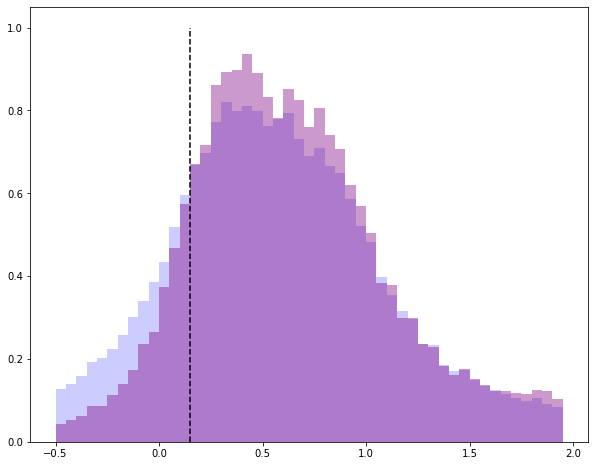

In [27]:
plt.hist(t["r"]-t["z"], np.arange(-0.5, 2, 0.05), alpha=0.2, color='blue', density=True)
plt.hist(t["r"][detect]-t["z"][detect], np.arange(-0.5, 2, 0.05), alpha=0.4, color='purple', density=True)
#plt.hist(t["r"][elgs]-t["z"][elgs], np.arange(-0.5, 2, 0.05), alpha=0.3, color='orange', density=True)
plt.vlines(0.15,0,1,'k','dashed') 

(array([0.02139037, 0.02722411, 0.03208556, 0.04472533, 0.04958678,
        0.07389402, 0.10111813, 0.12834225, 0.20612543, 0.27321342,
        0.45308702, 0.61351483, 0.79533301, 0.93145357, 0.95964998,
        0.97131745, 0.84200292, 0.90909091, 0.82741857, 0.79436072,
        0.77297035, 0.74477394, 0.79824988, 0.71657754, 0.7107438 ,
        0.72143899, 0.62323772, 0.62615459, 0.51920272, 0.48614487,
        0.44044725, 0.37530384, 0.28001945, 0.2654351 , 0.26057365,
        0.27029655, 0.24112786, 0.2839086 , 0.27613029, 0.25862907,
        0.2177929 , 0.18376276, 0.1614001 , 0.1701507 , 0.14292659,
        0.10889645, 0.11278561, 0.10111813, 0.07486631]),
 array([-5.00000000e-01, -4.50000000e-01, -4.00000000e-01, -3.50000000e-01,
        -3.00000000e-01, -2.50000000e-01, -2.00000000e-01, -1.50000000e-01,
        -1.00000000e-01, -5.00000000e-02, -1.11022302e-16,  5.00000000e-02,
         1.00000000e-01,  1.50000000e-01,  2.00000000e-01,  2.50000000e-01,
         3.00000000e-01,  

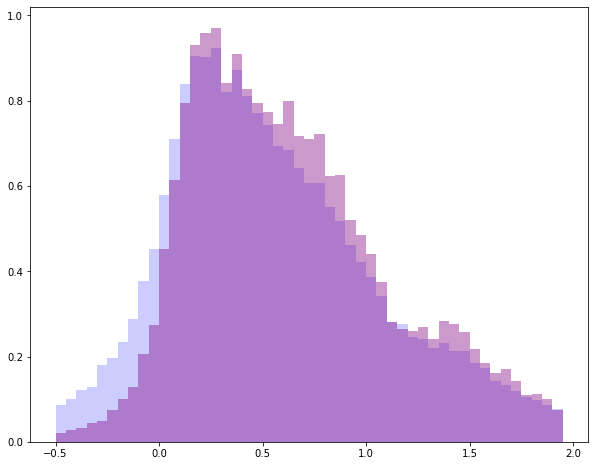

In [28]:
plt.hist(t["g"]-t["r"], np.arange(-0.5, 2, 0.05), alpha=0.2, color='blue', density=True)
plt.hist(t["g"][detect]-t["r"][detect], np.arange(-0.5, 2, 0.05), alpha=0.4, color='purple', density=True)
#plt.hist(t["g"][elgs]-t["r"][elgs], np.arange(-0.5, 2, 0.05), alpha=0.3, color='orange', density=True)
#plt.vlines(0.15,0,1,'k','dashed') 